In [ ]:
import torch
from torchvision import models
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import json
import torchvision.transforms.functional as TF


e:\anaconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import json
import numpy as np

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Load the JSON file with class definitions
with open('labels.json') as json_file:
    class_definitions = json.load(json_file)

# Create a mapping from color tuples to class ids
color_to_classid = {tuple(class_def["color"]): class_def["classid"] for class_def in class_definitions}

# Modify the dataset class to convert the masks
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, color_to_classid, transform=None, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.color_to_classid = color_to_classid
        self.transform = transform
        self.target_size = target_size
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)  # Adjust if mask names differ
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Resize image and mask
        image = TF.resize(image, self.target_size)
        mask = TF.resize(mask, self.target_size, interpolation=Image.NEAREST)

        mask = self.rgb_to_mask(mask)

        if self.transform:
            image = self.transform(image)

        return image, mask

    def rgb_to_mask(self, rgb_mask):
        """Convert an RGB mask to a single-channel mask where each pixel value corresponds to the class label."""
        mask = np.zeros((rgb_mask.size[1], rgb_mask.size[0]), dtype=np.uint8)
        for color, classid in self.color_to_classid.items():
            # Find pixels with the current color and set their classid
            mask[np.all(np.array(rgb_mask) == np.array(color).reshape(1, 1, 3), axis=-1)] = classid
        return torch.from_numpy(mask).long()

# Now you can create your dataset and dataloader
dataset = CustomSegmentationDataset(image_dir='seq_1/frames/', mask_dir='seq_1/labels/', color_to_classid=color_to_classid, transform=transform, target_size=(128,128))
dataloader = DataLoader(dataset, batch_size=18, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes=7
# Load a pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))  # Replace the classifier with the number of classes you have
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))  # Do the same for the auxiliary classifier
#model.load_state_dict(torch.load('fine_tuned_model.pth'))

model.to('cuda')


e:\anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images = images.to('cuda')
        masks = masks.to('cuda')

        optimizer.zero_grad()
        output = model(images)['out']
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print("done")

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
Epoch 1/25, Loss: 1.5517455458641052
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
Epoch 2/25, Loss: 0.9660086810588837
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
Epoch 3/25, Loss: 0.7673919220765432
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
Epoch 4/25, Loss: 0.6421373387177786
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
Epoch 5/25, Loss: 0.5482693403959275
done
done
done
done
done
done
done
done
done
done
done
done
done


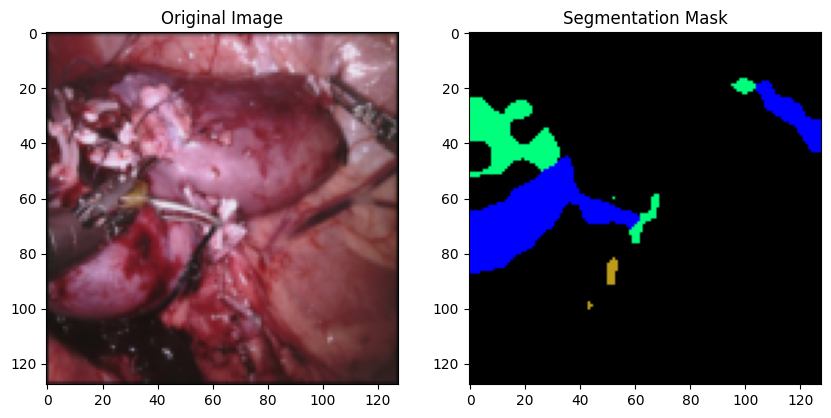

In [ ]:
import matplotlib.pyplot as plt
from torchvision import models
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

# Assuming you have the same transform used during training
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the trained model
num_classes = 7  # Update with your number of classes
model.eval()

def decode_segmap(image, nc=num_classes):
    label_colors = np.array([(0, 0, 0),  # 0=background
                             # Add more colors for each class label
                             (0, 0, 255),
                             (187, 155, 25),
                             (0, 255, 125),
                             (255, 255, 125),
                             (123, 15, 175),
                             (12, 255, 141),
                             # ... add colors for all your classes
                             ])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Function to perform inference and visualization
# Function to perform inference and visualization
def predict_and_visualize(image_path, model, transform):
    image = Image.open(image_path).convert("RGB")
    # Resize image if necessary
    image = T.Resize((128, 128))(image)
    image_transformed = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_transformed)['out']
        # Get the prediction by taking the argmax across the channel dimension
        output_predictions = output.squeeze().argmax(0).cpu().numpy()

    # The output_predictions should have a shape of (height, width)
    assert output_predictions.ndim == 2, "Output prediction should be 2D"

    # Convert the output predictions to a color mask
    segmap = decode_segmap(output_predictions)

    # Display the original image and the segmentation mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.resize((output_predictions.shape[1], output_predictions.shape[0])))  # Resize image to match the mask
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmap)
    plt.title('Segmentation Mask')

    plt.show()

# Run inference and visualization on a test image
image_path = 'seq_1/frames/frame144 (2).png'  # Update with your test image path
predict_and_visualize(image_path, model, transform)

In [ ]:
torch.save(model.state_dict(), 'fine_tuned_model2_25epochs.pth')


In [ ]:

# Make sure to set the model to evaluation mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import json

# Load the labels.json file
with open('labels.json', 'r') as file:
    class_info = json.load(file)

# Generate a mapping from color tuples to class IDs
color_to_classid = {tuple(class_def["color"]): class_def["classid"] for class_def in class_info}


def convert_rgb_to_class_labels(rgb_image, color_to_classid):
    # Create an empty array for the class labels
    class_labels = np.zeros((rgb_image.shape[0], rgb_image.shape[1]), dtype=np.uint8)

    # Loop over the color to class ID mapping
    for color, class_id in color_to_classid.items():
        # Create a mask for pixels matching the current color
        color_mask = np.all(rgb_image == np.array(color).reshape(1, 1, 3), axis=-1)

        # Assign the class ID to the corresponding pixels in the class labels array
        class_labels[color_mask] = class_id

    return class_labels

image = Image.open(image_path).convert("RGB")
# Resize image if necessary
image = T.Resize((128, 128))(image)
image_transformed = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_transformed)['out']
    # Get the prediction by taking the argmax across the channel dimension
    output_predictions = output.squeeze().argmax(0).cpu().numpy()


def calculate_iou_f1(prediction, ground_truth, class_id):
    # Flatten the arrays to compare each pixel
    prediction_flat = (prediction == class_id).flatten()
    ground_truth_flat = (ground_truth == class_id).flatten()


    # Calculate intersection and union
    intersection = np.logical_and(prediction_flat, ground_truth_flat).sum()
    union = np.logical_or(prediction_flat, ground_truth_flat).sum()


    # Calculate IoU
    iou = intersection / union if union != 0 else 0

    # Calculate F1 score (Dice coefficient)
    f1 = (2 * intersection) / (prediction_flat.sum() + ground_truth_flat.sum()) if (prediction_flat.sum() + ground_truth_flat.sum()) != 0 else 0

    return iou, f1

def calculate_metrics_for_image(prediction, ground_truth, num_classes):
    iou_scores = []
    f1_scores = []

    for class_id in range(num_classes):
        iou, f1 = calculate_iou_f1(prediction, ground_truth, class_id)
        if iou !=0:
            iou_scores.append(iou)
        if f1 !=0 :
            f1_scores.append(f1)
    print(f1_scores)
    print(iou_scores)
    mean_iou = np.mean(iou_scores)
    mean_f1 = np.mean(f1_scores)

    return mean_iou, mean_f1

# Assuming you have the ground truth mask as an image file
ground_truth_path = 'seq_1/labels/frame144 (2).png'  # Update with the path to your ground truth mask

# Load and preprocess the ground truth mask
ground_truth_image = Image.open(ground_truth_path).convert('RGB')  # Convert to grayscale
ground_truth_image = T.Resize((128, 128))(ground_truth_image)  # Resize to match the model output
ground_truth_mask = np.array(ground_truth_image)
ground_truth_mask = convert_rgb_to_class_labels(ground_truth_mask, color_to_classid)


# Assuming output_predictions contains your predicted mask as a numpy array
mean_iou, mean_f1 = calculate_metrics_for_image(output_predictions, ground_truth_mask, num_classes)

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

[0.9673452932876436, 0.7561455260570304, 0.5, 0.5043859649122807]
[0.9367558071442514, 0.607905138339921, 0.3333333333333333, 0.33724340175953077]
Mean IoU: 0.5538
Mean F1 Score: 0.6820
